In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')
# !unzip '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data.zip' -d '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project'

Mounted at /content/drive


In [3]:
scores_df = pd.read_csv('scores.csv')
print(scores_df.head())

   Unnamed: 0                                  code  grade
0           0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1           1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2           2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3           3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4           4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0


In [6]:
data_path = "data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:29<00:00,  4.32it/s]


In [7]:
# let's see one of the conversations
#code2convos: keeps all the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


In [8]:
#Check if data is taken correctly
for file_code, convo_texts in list(code2convos.items())[:5]:  #Show the first 5 files
    print(file_code)
    for convo in convo_texts:
        print(f"Role: {convo['role']}, Text: {convo['text'][:50]}...")  #Show first 50 characters
    print("\n")


0031c86e-81f4-4eef-9e0e-28037abf9883
Role: user, Text: Load a CSV file into a Pandas in Python. The file ...
Role: assistant, Text: You can load a CSV file into a Pandas DataFrame in...
Role: user, Text: Provide Python code to understand a dataset using ...
Role: assistant, Text: You can use Pandas to understand a dataset by perf...
Role: user, Text: You will preprocess the data now
1. Check for miss...
Role: assistant, Text: To preprocess the dataset as per your requirements...
Role: user, Text: You already provide code for this but please recre...
Role: assistant, Text: Certainly, here's the code to shuffle the DataFram...
Role: user, Text: Calculate and Visualize the correlations of all fe...
Role: assistant, Text: To calculate and visualize the correlations of all...
Role: user, Text: ValueError: could not convert string to float: 'Ch...
Role: assistant, Text: The error message "ValueError: could not convert s...
Role: user, Text: Dataset includes both numerical and categorical co.

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [9]:
###Reduce noises from texts###

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [11]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [12]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
###Perform TF-IDF vectorization on pre-processed texts###
# vectorizer = TfidfVectorizer(
#      max_df=0.85,
#      min_df=0.01,
#      ngram_range=(1,2),
#      stop_words='english'
#  )

#vectorizer.fit(prompts_cleaned + questions_cleaned)

#prompts_tfidf = vectorizer.transform(prompts_cleaned)
#questions_tfidf = vectorizer.transform(questions_cleaned)

In [ ]:
# #REAL ONE
# vectorizer = TfidfVectorizer()
# vectorizer = vectorizer.fit(prompts + questions)

In [ ]:
# questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
# questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# code2prompts_tf_idf = dict()
# for code, user_prompts in code2prompts.items():
#   if len(user_prompts) == 0:
#     # some files have issues
#     print(code+".html")
#     continue
#   prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
#   code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
# code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# code2cosine = dict()
# for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
#     code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [ ]:
# questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [ ]:
# code2questionmapping = dict()
# for code, cosine_scores in code2cosine.items():
#   code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


#  question_mapping_scores = pd.DataFrame(code2questionmapping).T
#  question_mapping_scores.reset_index(inplace=True)
#  question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
#  question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

#  question_mapping_scores
# #0 label stands for no copy paste done in any of the questions and 1 label stands for copy paste done for at least one question'''

NameError: name 'code2cosine' is not defined

In [19]:
import gensim.downloader
from gensim.models import Word2Vec

sentences = [prompt.split() for prompt in prompts]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [20]:
import gensim.downloader as api
import numpy as np

def document_vector(word2vec_model, doc):
    words = doc.split()
    word_vectors = []

    for word in words:
        if word in word2vec_model.wv:
            word_vectors.append(word2vec_model.wv[word])

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)

    document_vector = np.mean(word_vectors, axis=0)
    return document_vector

code2_word2vec_prompts = dict()

for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      # some files have issues
      print(code+".html")
      continue

  word2_vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in user_prompts],
                               columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})
  code2_word2vec_prompts[code] = word2_vec

question_word2vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in questions], columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [21]:
from sklearn.preprocessing import normalize
code2cosine = dict()
for code, user_prompts_word2vec in code2_word2vec_prompts.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(question_word2vec, user_prompts_word2vec))

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.954705,0.925687,0.905314,0.887660,0.950095,0.893906,0.843839,0.854410,0.864186
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.956845,0.936065,0.958633,0.979804,0.938943,0.998853,0.977700,0.926458,0.973685
2,041f950b-c013-409a-a642-cffff60b9d4b,0.946720,0.910845,0.929257,0.818378,0.937861,0.866871,0.891894,0.928035,0.823303
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.943840,0.910059,0.872733,0.852066,0.894239,0.897405,0.908719,0.924651,0.965747
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.966346,0.932263,0.956731,0.945295,0.949234,0.981832,0.976330,0.995838,0.962205
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.962564,0.946351,0.914515,0.821291,0.898056,0.916371,0.998817,0.997681,0.984870
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.959086,0.935106,0.926354,0.979566,0.991403,0.990002,0.957121,0.996500,0.964159
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.958439,0.966504,0.992270,0.991840,0.994895,0.994600,0.987738,0.985907,0.967924
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.938645,0.980083,0.999990,0.980327,0.998077,0.994077,0.999959,0.999971,0.980088


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [22]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

'''# Adding Copying and Pasting Indicator
threshold_copy_paste = 0.8  # Set your desired threshold for copying and pasting

# for index, row in question_mapping_scores.iterrows():
#   for col in range(1, 10):
#     if row.iloc[col] > threshold_copy_paste:
#       question_mapping_scores.iat[index, col] = 1

question_mapping_scores.head()
# question_mapping_scores["copy_paste_indicator"] = (question_mapping_scores.iloc[:, 1:].max(axis=1) > threshold_copy_paste).astype(int)'''

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


'# Adding Copying and Pasting Indicator\nthreshold_copy_paste = 0.8  # Set your desired threshold for copying and pasting\n\n# for index, row in question_mapping_scores.iterrows():\n#   for col in range(1, 10):\n#     if row.iloc[col] > threshold_copy_paste:\n#       question_mapping_scores.iat[index, col] = 1\n\nquestion_mapping_scores.head()\n# question_mapping_scores["copy_paste_indicator"] = (question_mapping_scores.iloc[:, 1:].max(axis=1) > threshold_copy_paste).astype(int)'

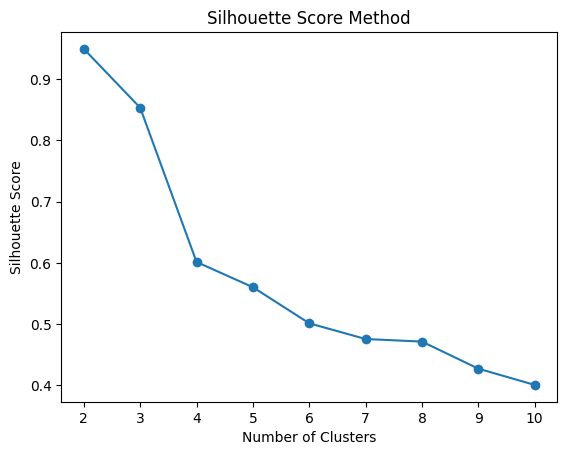

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

X = pd.DataFrame.from_dict(code2features, orient='index').fillna(0)

# Specify a range of cluster numbers to try
cluster_range = range(2, 11)

silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Set n_init explicitly to 10 in order to suppress the warning
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot the Silhouette Score for different numbers of clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [24]:
#k-means clustering and setting the number of cluster based on the highest silhouette score

from sklearn.cluster import KMeans
import pandas as pd


X = pd.DataFrame.from_dict(code2features, orient='index').fillna(0)

# Number of clusters based on the silhouette score
n_clusters = 2

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)


X['cluster_label'] = cluster_labels


#Cluster 0: Detailed Interactors (students who provide detailed prompts and responses)
#Cluster 1: Concise Interactors (students who use shorter prompts and responses)
cluster_label_mapping = {0: "Detailed Interactors", 1: "Concise Interactors"}
X['cluster_label'] = X['cluster_label'].map(cluster_label_mapping)
X['cluster_label']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0031c86e-81f4-4eef-9e0e-28037abf9883    Detailed Interactors
0225686d-b825-4cac-8691-3a3a5343df2b    Detailed Interactors
041f950b-c013-409a-a642-cffff60b9d4b    Detailed Interactors
04f91058-d0f8-4324-83b2-19c671f433dc    Detailed Interactors
089eb66d-4c3a-4f58-b98f-a3774a2efb34    Detailed Interactors
                                                ...         
f24219d6-07f0-4baf-80ac-18475dc5b66f    Detailed Interactors
f2f18684-4a16-4c05-a2d1-c0f96d1de869    Detailed Interactors
f852596d-fdca-45aa-9050-d4f76ce6a53c    Detailed Interactors
f8ec3336-fd48-4654-ad98-62ccfb96d096    Detailed Interactors
fb8de815-224c-4d06-9fd4-7156d1a9920d    Detailed Interactors
Name: cluster_label, Length: 123, dtype: object

In [25]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [26]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


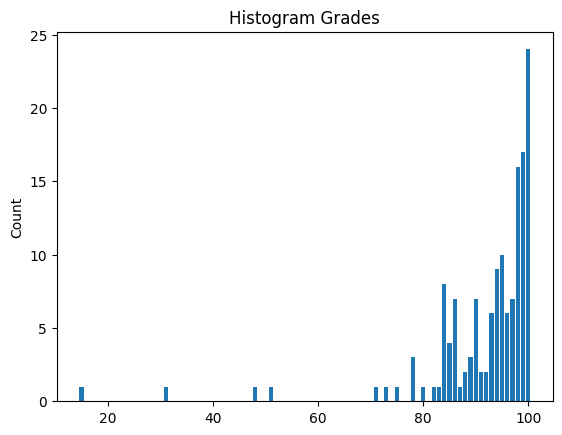

In [27]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [28]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [29]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.954705,0.925687,0.905314,0.887660,0.950095,0.893906,0.843839,0.854410,0.864186
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.956845,0.936065,0.958633,0.979804,0.938943,0.998853,0.977700,0.926458,0.973685
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.946720,0.910845,0.929257,0.818378,0.937861,0.866871,0.891894,0.928035,0.823303
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.943840,0.910059,0.872733,0.852066,0.894239,0.897405,0.908719,0.924651,0.965747
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.966346,0.932263,0.956731,0.945295,0.949234,0.981832,0.976330,0.995838,0.962205


#### Merging scores with features

In [113]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")

In [31]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 17) (122,)


#### Train/Test split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing

In [115]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [34]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 0.0
Node 2 has MSE 126.39409722222263
Node 3 has MSE 64.35004526935154
Node 4 has MSE 118.06243496358093
Node 5 has MSE 148.79338842975267
Node 6 has MSE 137.55555555555566
Node 7 has MSE 0.0
Node 8 has MSE 6.25
Node 9 has MSE 0.0
Node 10 has MSE 0.0
Node 11 has MSE 50.1875
Node 12 has MSE 13.555555555554747
Node 13 has MSE 0.0
Node 14 has MSE 4.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 24.0
Node 18 has MSE 4.6875
Node 19 has MSE 0.0
Node 20 has MSE 0.0
Node 21 has MSE 0.0
Node 22 has MSE 55.88750000000073
Node 23 has MSE 28.691358024692818
Node 24 has MSE 17.422222222221535
Node 25 has MSE 18.484375
Node 26 has MSE 0.22222222222262644
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 5.839999999999236
Node 30 has MSE 0.6875
Node 31 has MSE 0.25
Node 32 has MSE 0.0
Node 33 has MSE 0.0
Node 34 has MSE 3.3469387755085336
Node 35 has MSE 0.23999999999978172
Node 36 has MSE 0.0
Node 37 has MSE 0.0
Node 38 has MSE 0.25
N

In [35]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create a Random Forest Regressor with regularization (controlled by n_estimators and max_depth)
regressor = RandomForestRegressor(n_estimators=200)
regressor.fit(X_train, y_train)
max_depth = max(tree.tree_.max_depth for tree in regressor.estimators_)
print(f"Maximum depth of any tree in the RandomForestRegressor: {max_depth}")

n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]
max_features = ["auto", "sqrt"]
max_depth_arr = [2, 4, 6, 8, 10]
min_sample_splits = [2, 4, 6, 8]
min_sample_leafs = [1, 2]
bootstrap = [True, False]

param_grid = {
    'max_depth': max_depth_arr,
    'min_samples_split': min_sample_splits,
    'n_estimators': n_estimators,
    'max_features': max_features,
    'min_samples_leaf': min_sample_leafs,
    'bootstrap': bootstrap
}

regressor = RandomForestRegressor()
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, verbose=2, n_jobs=4)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Maximum depth of any tree in the RandomForestRegressor: 19
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 56}

In [111]:
regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=,
    bootstrap=True,
    max_features=
)

regressor.fit(X_train, y_train)

# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Map predictions to the (0, 100) range
y_train_pred = np.clip(y_train_pred, 0, 100)
y_test_pred = np.clip(y_test_pred, 0, 100)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST: ",r2_score(y_test, y_test_pred)*100)

# Cross-validation
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print("Cross-Validation Scores:", cv_scores)

MSE Train: 76.47860079431574
MSE TEST: 100.58213065220059
R2 Train: 0.5320129688091633
R2 TEST:  10.406989627988805
Cross-Validation Scores: [328.49414636  86.55967154  35.48618273 591.25276455  20.83793479]
